# KLASIFIKASI CITRA BUAH APEL SEGAR DAN BUAH APEL BUSUK 
---

## Nama Anggota
---

### Farid Nanda Syauqi          : F1D02310050
### Sucitasari Rahmadani        : F1D02310138
### Muhammad Alfath Mavianza    : F1D02310077
### Alysa Meliana               : F1D02310035
---

# IMPORT LIBRARY
Bagian kode ini mengimpor berbagai library yang dibutuhkan untuk proses klasifikasi citra buah apel segar dan busuk. Library seperti `os` digunakan untuk manajemen file, `cv2` (OpenCV) untuk membaca dan memproses citra, serta `matplotlib.pyplot` dan `seaborn` untuk visualisasi. `numpy` dan `pandas` digunakan untuk manipulasi data numerik dan tabular. Proses pembagian data, pelatihan, dan validasi model dilakukan dengan `scikit-learn`, yang juga menyediakan algoritma klasifikasi seperti Random Forest, SVM, dan KNN, serta metrik evaluasi seperti akurasi, precision, recall, dan F1-score. Selain itu, `skimage.feature` digunakan untuk ekstraksi fitur tekstur menggunakan GLCM (gray-level co-occurrence matrix), dan `scipy.stats` digunakan untuk menghitung entropi citra sebagai salah satu fitur statistik.

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

# Data Loading
Kode ini digunakan untuk membaca dataset citra apel dari folder bernama `dataApel`, yang berisi subfolder sesuai dengan label kelas (misalnya "Segar" dan "Busuk"). Untuk setiap gambar dalam subfolder, gambar dibaca menggunakan OpenCV dan dikonversi menjadi citra grayscale. Gambar yang berhasil dibaca disimpan dalam list `data`, sedangkan label kelasnya (nama subfolder) dimasukkan ke dalam list `labels`, dan nama file-nya (tanpa ekstensi) dimasukkan ke dalam `file_name`. Setelah seluruh data diproses, ketiga list tersebut diubah menjadi array NumPy untuk memudahkan proses selanjutnya seperti ekstraksi fitur atau pelatihan model.


In [2]:
data = []
labels = []
file_name = []

for sub_folder in sorted(os.listdir("dataApel")):
    folder_path = os.path.join("dataApel", sub_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
        data.append(img)
        labels.append(sub_folder)
        file_name.append(os.path.splitext(filename)[0])

data = np.array(data, dtype=object)
labels = np.array(labels)
file_name = np.array(file_name)

## Data Understanding
Kode ini digunakan untuk melakukan *data understanding* dengan cara menganalisis distribusi jumlah gambar pada setiap label dalam dataset. Pertama, kode menghitung jumlah kemunculan masing-masing label menggunakan `np.unique` dengan opsi `return_counts=True`, lalu mengurutkan label dan jumlahnya agar lebih rapi saat divisualisasikan. Visualisasi dilakukan menggunakan grafik batang (bar chart) untuk menampilkan jumlah gambar per label, lengkap dengan rotasi label agar mudah dibaca. Setelah itu, informasi jumlah total data, jumlah label unik, dan distribusi data per label dicetak ke terminal untuk memberikan gambaran umum tentang keseimbangan kelas dalam dataset citra apel yang digunakan.

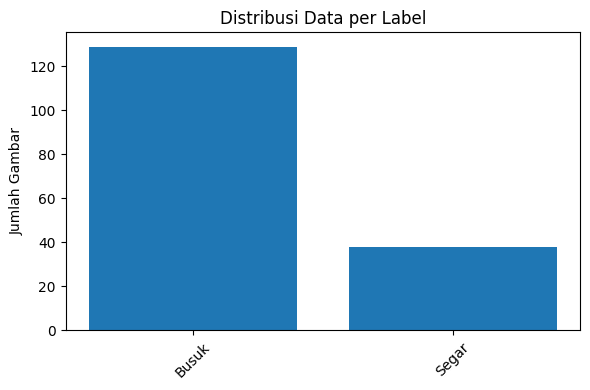

Jumlah total data: 167
Jumlah label unik: 2
Distribusi label:
  Busuk: 129 file
  Segar: 38 file


In [3]:
unique_labels, counts = np.unique(labels, return_counts=True)

sorted_indices = np.argsort(unique_labels)
sorted_labels = unique_labels[sorted_indices]
sorted_counts = counts[sorted_indices]

plt.figure(figsize=(6, 4))
plt.bar(sorted_labels, sorted_counts)
plt.xticks(rotation=45)
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Data per Label")
plt.tight_layout()
plt.show()

print("Jumlah total data:", len(labels))
print("Jumlah label unik:", len(np.unique(labels)))
print("Distribusi label:")
for label, count in zip(sorted_labels, sorted_counts):
    print(f"  {label}: {count} file")

## Sampel Data
Kode ini digunakan untuk menampilkan contoh visual dari citra apel berdasarkan labelnya guna mendukung proses *data understanding*. Pertama, dibuat daftar label unik dan dictionary `label_to_images` untuk menyimpan hingga maksimal 5 gambar dari setiap label. Kemudian, kode mengisi dictionary tersebut dengan citra dari dataset sesuai labelnya. Terakhir, untuk setiap label, ditampilkan hingga lima gambar dalam satu baris menggunakan subplot, sehingga memudahkan dalam mengenali karakteristik visual dari masing-masing kelas (misalnya perbedaan antara apel segar dan busuk). Visualisasi ini membantu dalam memahami variasi citra yang dimiliki setiap kelas sebelum masuk ke tahap preprocessing dan klasifikasi.

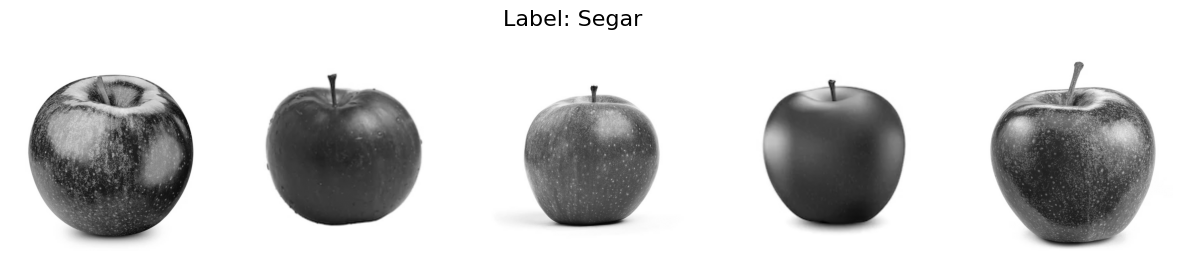

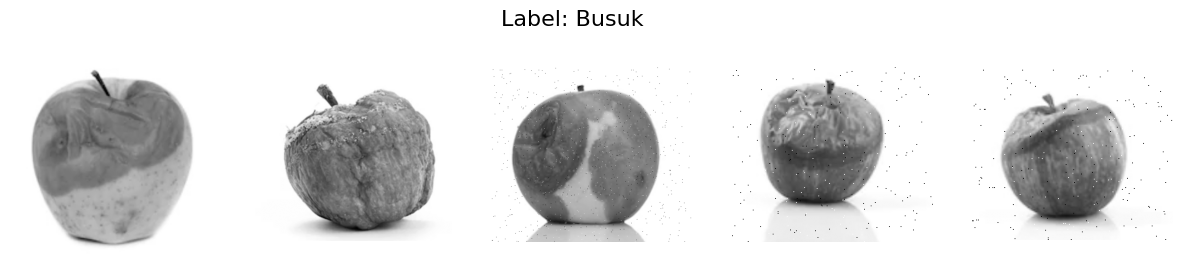

In [4]:
# Misal label uniknya seperti ini:
unique_labels = list(set(labels))

# Menyimpan gambar per label
label_to_images = {label: [] for label in unique_labels}

# Kumpulkan maksimal 5 gambar per label
for img, label in zip(data, labels):
    if len(label_to_images[label]) < 5:
        label_to_images[label].append(img)

# Tampilkan gambar-gambar tersebut
for label in unique_labels:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f'Label: {label}', fontsize=16)
    
    for i in range(5):
        if i < len(label_to_images[label]):
            axs[i].imshow(label_to_images[label][i], cmap='gray')
            axs[i].axis('off')
        else:
            axs[i].axis('off')  # Kosong jika kurang dari 5 data
    
    plt.show()

# DATA PREPARATION
## Data Augmentation
Kode ini mendefinisikan dua fungsi untuk augmentasi citra grayscale, yaitu `flip` dan `rotate`. Fungsi `flip` digunakan untuk membalik citra berdasarkan sumbu tertentu, yaitu `'x'` untuk membalik secara vertikal dan `'y'` untuk horizontal, dengan cara menyalin piksel ke posisi yang terbalik berdasarkan sumbu yang dipilih. Sementara itu, fungsi `rotate` digunakan untuk memutar citra sebesar sudut tertentu (dalam derajat) terhadap titik pusat citra. Fungsi ini menghitung posisi piksel baru dengan menggunakan rumus rotasi dua dimensi dan menyalin nilai piksel dari koordinat asal ke hasil rotasi jika berada dalam batas citra. Kedua fungsi ini penting untuk menambah variasi data latih dalam proses klasifikasi agar model menjadi lebih robust terhadap rotasi dan orientasi objek.

In [5]:
def flip(frag, mirror):

    sumbu = mirror

    baris, kolom = frag.shape
        
    flip = np.zeros_like(frag)

    for i in range(baris):
        for j in range(kolom):
            new_baris = baris - i - 1
            new_kolom = kolom - j - 1

            if(sumbu == 'y'): flip[i, new_kolom] = frag[i, j]
                
            elif(sumbu == 'x'): flip[new_baris, j] = frag[i, j]

    return flip

def rotate(frag, derajat):

    y, x = frag.shape

    angle = -np.radians(derajat)

    pusat_x = x / 2
    pusat_y = y / 2

    rotasi = np.zeros_like(frag)

    for i in range(y):
        for j in range(x):
            new_x = j - pusat_x
            new_y = i - pusat_y

            new_kolom = int(new_x * np.cos(angle) - new_y * np.sin(angle) + pusat_x)
            new_baris = int(new_x * np.sin(angle) + new_y * np.cos(angle) + pusat_y)

            if 0 <= new_baris < y and 0 <= new_kolom < x:
                rotasi[i, j] = frag[new_baris, new_kolom]

    return rotasi

## Augmentasi Label dengan Data yang Minim
Kode ini melakukan augmentasi data secara selektif hanya pada citra dengan label 'Segar', guna menyeimbangkan jumlah data antar kelas atau meningkatkan keberagaman data latih. Pertama, citra asli beserta label dan nama file dimasukkan ke dalam list hasil augmentasi. Jika labelnya adalah 'Segar', maka citra akan mengalami tiga jenis augmentasi tambahan: pembalikan horizontal (flip sumbu-Y), pembalikan vertikal (flip sumbu-X), dan rotasi sebesar 15 derajat searah jarum jam. Setiap hasil augmentasi dimasukkan kembali ke dalam list data_augmented beserta label dan nama file yang telah diperbarui untuk menandai jenis transformasi yang dilakukan. Pendekatan ini membantu memperkaya variasi data kelas 'Segar' agar model klasifikasi lebih mampu mengenali pola yang berbeda dari kelas tersebut.

In [6]:
# Augmentasi hanya pada label 'segar'
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

for i in range(len(data)):
    original = data[i]
    label = labels[i]
    name = file_name[i]

    # Tambahkan gambar asli
    data_augmented.append(original)
    labels_augmented.append(label)
    file_name_augmented.append(f"{name}_original")
    paths_augmented.append("")

    # Lakukan augmentasi jika labelnya 'segar'
    if label == 'Segar':
        # Flip horizontal
        flipped_y = flip(original, 'y')
        data_augmented.append(flipped_y)
        labels_augmented.append(label)
        file_name_augmented.append(f"{name}_flipY")
        paths_augmented.append("")

        # Flip vertical
        flipped_x = flip(original, 'x')
        data_augmented.append(flipped_x)
        labels_augmented.append(label)
        file_name_augmented.append(f"{name}_flipX")
        paths_augmented.append("")

        # Rotasi 15 derajat
        rotated_15 = rotate(original, 15)
        data_augmented.append(rotated_15)
        labels_augmented.append(label)
        file_name_augmented.append(f"{name}_rot15")
        paths_augmented.append("")

## Data Understanding
Kode ini digunakan untuk melakukan *data understanding* dengan cara menganalisis distribusi jumlah gambar pada setiap label dalam dataset. Pertama, kode menghitung jumlah kemunculan masing-masing label menggunakan `np.unique` dengan opsi `return_counts=True`, lalu mengurutkan label dan jumlahnya agar lebih rapi saat divisualisasikan. Visualisasi dilakukan menggunakan grafik batang (bar chart) untuk menampilkan jumlah gambar per label, lengkap dengan rotasi label agar mudah dibaca. Setelah itu, informasi jumlah total data, jumlah label unik, dan distribusi data per label dicetak ke terminal untuk memberikan gambaran umum tentang keseimbangan kelas dalam dataset citra apel yang digunakan.

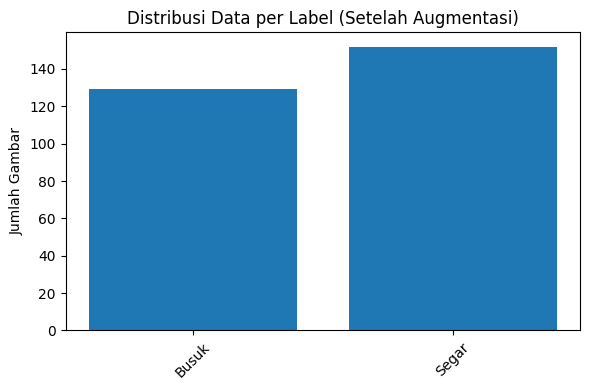

Jumlah total data setelah augmentasi: 281
Jumlah label unik: 2
Distribusi label:
  Busuk: 129 file
  Segar: 152 file


In [7]:
unique_labels, counts = np.unique(labels_augmented, return_counts=True)

sorted_indices = np.argsort(unique_labels)
sorted_labels = unique_labels[sorted_indices]
sorted_counts = counts[sorted_indices]

plt.figure(figsize=(6, 4))
plt.bar(sorted_labels, sorted_counts)
plt.xticks(rotation=45)
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Data per Label (Setelah Augmentasi)")
plt.tight_layout()
plt.show()

print("Jumlah total data setelah augmentasi:", len(labels_augmented))
print("Jumlah label unik:", len(np.unique(labels_augmented)))
print("Distribusi label:")
for label, count in zip(sorted_labels, sorted_counts):
    print(f"  {label}: {count} file")

## Sampel Data Hasil Augmentasi
Kode ini mencari dan menampilkan contoh visual augmentasi dari satu citra asli dengan label `'Segar'`. Pertama, kode mencari indeks gambar yang memiliki label target `'Segar'`. Jika ditemukan, satu gambar asli diambil kemudian dilakukan tiga jenis augmentasi: flip vertikal (flip X), flip horizontal (flip Y), dan rotasi sebesar 15 derajat. Keempat citra—gambar asli dan ketiga hasil augmentasi—kemudian ditampilkan berdampingan menggunakan subplot agar mudah dibandingkan secara visual. Visualisasi ini membantu memverifikasi bahwa augmentasi berhasil dilakukan dan memberikan gambaran bagaimana variasi citra yang dihasilkan dari proses augmentasi tersebut.

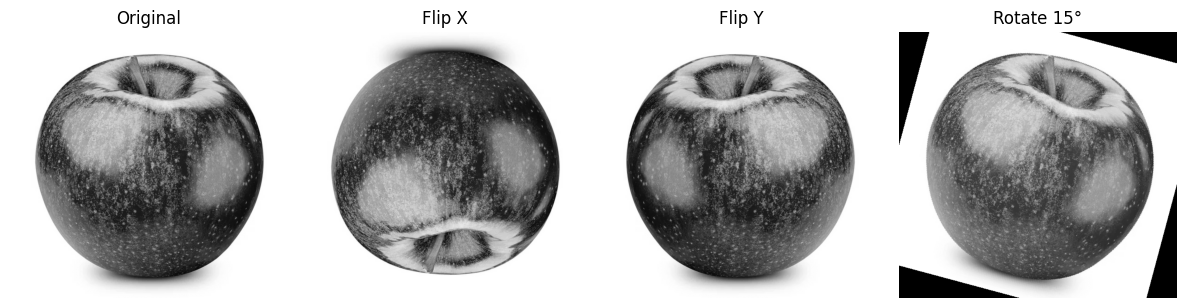

In [8]:
label_target = 'Segar'

# Cari indeks gambar asli dengan label target
original_indices = [i for i, lbl in enumerate(labels) if lbl == label_target]

if not original_indices:
    print(f"Tidak ada gambar dengan label '{label_target}' di data asli.")
else:
    # Ambil satu gambar asli
    img_ori = data[original_indices[0]]

    # Buat hasil augmentasi dari gambar asli
    flip_x_img = flip(img_ori, 'x')
    flip_y_img = flip(img_ori, 'y')
    rotate_img = rotate(img_ori, 15)  # contoh rotate 15 derajat

    # Plot gambar asli dan hasil augmentasi
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 4, 1)
    plt.imshow(img_ori, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(flip_x_img, cmap='gray')
    plt.title('Flip X')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(flip_y_img, cmap='gray')
    plt.title('Flip Y')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(rotate_img, cmap='gray')
    plt.title('Rotate 15°')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Preprocessing
pada percobaan kedua ini, kami menggunakan 3 buah preprocessing yaitu grayscale, resize, dan median filter. 

1. Grayscale : Grayscale kami gunakan untuk menyederhanakan informasi warna pada gambar menjadi satu kanal intensitas. Dengan mengubah citra berwarna menjadi citra grayscale, proses komputasi menjadi lebih ringan dan fokus analisis lebih tertuju pada bentuk, pola, dan tekstur dibandingkan informasi warna. Ini sangat berguna terutama pada dataset yang tidak terlalu bergantung pada warna untuk klasifikasi.

2. Resize : Setelah diubah ke grayscale, gambar kemudian di-resize ke dimensi yang seragam menggunakan metode nearest neighbor. Tujuan utama dari proses ini adalah untuk menyeragamkan ukuran seluruh gambar dalam dataset sehingga dapat diproses oleh model secara konsisten. Resize juga membantu menyesuaikan dimensi gambar dengan input layer dari model machine learning atau deep learning yang digunakan.

3. Median Filter : Tahapan terakhir adalah penerapan median filter untuk mengurangi noise yang mungkin terdapat pada citra. Filter ini efektif dalam menghilangkan noise impuls (seperti salt and pepper noise) dengan tetap mempertahankan tepi dan detail penting dari gambar. Filter bekerja dengan menggantikan setiap piksel dengan nilai median dari lingkungan tetangganya, sehingga hasil akhirnya lebih bersih dan stabil untuk diproses lebih lanjut.

In [9]:
def resize(img, baris_baru, kolom_baru):
    baris_asli, kolom_asli = img.shape

    resized_img = np.zeros((baris_baru, kolom_baru), dtype=np.uint8)

    for i in range(baris_baru):
        for j in range(kolom_baru):
            x = int(i * baris_asli / baris_baru)
            y = int(j * kolom_asli / kolom_baru)

            x = min(x, baris_asli - 1)
            y = min(y, kolom_asli - 1)

            resized_img[i, j] = img[x, y]

    return resized_img

def median_filter(img, x, y):
    baris, kolom = img.shape
    padding_x = x//2
    padding_y = y//2
    canvas1 = np.zeros_like(img, dtype=img.dtype)
    canvas2 = np.pad(img, ((padding_x, padding_x), (padding_y, padding_y)), mode='edge')
    
    for i in range(baris):
        for j in range(kolom):
            window = canvas2[i:i+x, j:j+y]
            median = np.median(window)
            canvas1[i, j] = median

    return canvas1

## Preprocessing  
Kode berikut melakukan preprocessing terhadap setiap gambar dalam `data_augmented` dengan tiga tahapan utama, yaitu grayscale, resize, dan median filter. Gambar pertama-tama diubah kedalam format frayscale untuk memudahkan preprocessing. Gambar kemudian diubah ukurannya menjadi 200×200 piksel menggunakan metode nearest neighbor agar seluruh data memiliki dimensi yang konsisten. Setelah itu, median filter 3×3 diterapkan untuk mengurangi noise tanpa menghilangkan detail penting pada citra. Hasil dari kedua proses ini disimpan ke dalam list `dataPreprocessed` untuk digunakan pada tahap selanjutnya.

In [10]:
dataPreprocessed = []
for i in range(len(data_augmented)):
    img = data_augmented[i]

    img_resize = resize(img, 200, 200)

    img_filter = median_filter(img_resize, 3, 3)

    dataPreprocessed.append(img_filter)

## Sampel Data Hasil Preprocessing
Kode ini digunakan untuk menampilkan contoh visual dari citra apel berdasarkan labelnya guna mendukung proses *data understanding*. Pertama, dibuat daftar label unik dan dictionary `label_to_images` untuk menyimpan hingga maksimal 5 gambar dari setiap label. Kemudian, kode mengisi dictionary tersebut dengan citra dari dataset sesuai labelnya. Terakhir, untuk setiap label, ditampilkan hingga lima gambar dalam satu baris menggunakan subplot, sehingga memudahkan dalam mengenali karakteristik visual dari masing-masing kelas (misalnya perbedaan antara apel segar dan busuk). Visualisasi ini membantu dalam memahami variasi citra yang dimiliki setiap kelas sebelum masuk ke tahap preprocessing dan klasifikasi.

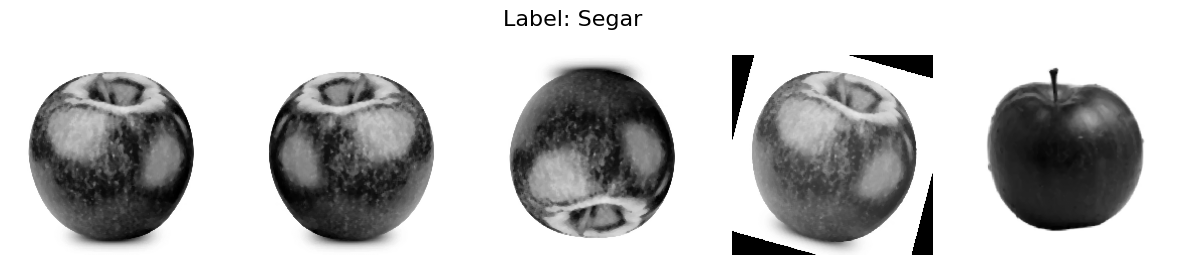

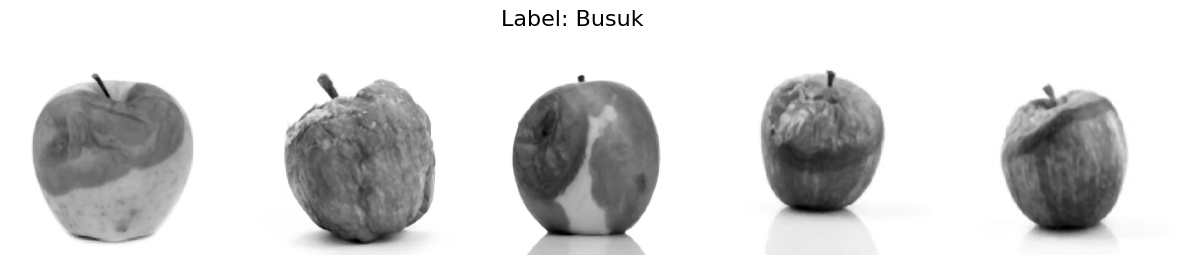

In [11]:
# Misal label uniknya seperti ini:
unique_labels = list(set(labels_augmented))

# Menyimpan gambar per label
label_to_images = {label: [] for label in unique_labels}

# Kumpulkan maksimal 5 gambar per label
for img, label in zip(dataPreprocessed, labels_augmented):
    if len(label_to_images[label]) < 5:
        label_to_images[label].append(img)

# Tampilkan gambar-gambar tersebut
for label in unique_labels:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f'Label: {label}', fontsize=16)
    
    for i in range(5):
        if i < len(label_to_images[label]):
            axs[i].imshow(label_to_images[label][i], cmap='gray')
            axs[i].axis('off')
        else:
            axs[i].axis('off')  # Kosong jika kurang dari 5 data
    
    plt.show()

## Feature Extraction
Kode ini mendefinisikan fungsi `glcm` untuk menghitung *Gray-Level Co-occurrence Matrix* (GLCM) dari citra grayscale berdasarkan sudut tertentu (0, 45, 90, atau 135 derajat). Fungsi menerima input citra dan derajat sudut, kemudian mengonversi sudut tersebut ke radian yang diperlukan oleh fungsi `graycomatrix` dari library `skimage.feature`. GLCM dihitung dengan jarak piksel 1, diatur agar simetris dan ternormalisasi. Matriks GLCM ini sangat berguna untuk ekstraksi fitur tekstur pada citra, yang kemudian dapat digunakan dalam proses klasifikasi citra.

In [12]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

## Fungsi Ekstraksi Fitur Korelasi dari GLCM
Kode ini mendefinisikan fungsi `correlation` yang digunakan untuk mengekstrak fitur korelasi dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan `graycoprops` dari library `skimage.feature` dengan parameter `'correlation'` untuk menghitung tingkat korelasi antar piksel dalam citra berdasarkan GLCM yang diberikan. Nilai korelasi ini menggambarkan hubungan linier antara intensitas piksel yang berdekatan dan dapat menjadi fitur penting dalam analisis tekstur citra.

In [13]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

## Fungsi Ekstraksi Fitur Dissimilarity dari GLCM
Kode ini mendefinisikan fungsi `dissimilarity` untuk mengambil fitur dissimilarity dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan `graycoprops` dari `skimage.feature` dengan parameter `'dissimilarity'` untuk mengukur seberapa berbeda intensitas piksel yang berdekatan dalam citra. Nilai dissimilarity ini membantu dalam menangkap variasi tekstur dan perbedaan lokal pada citra, yang berguna untuk proses klasifikasi citra.

In [14]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

## Fungsi Ekstraksi Fitur Homogeneity dari GLCM
Kode ini mendefinisikan fungsi `homogenity` yang digunakan untuk mengekstrak fitur homogeneity dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan `graycoprops` dari library `skimage.feature` dengan parameter `'homogeneity'` untuk mengukur seberapa seragam tekstur dalam citra, yaitu seberapa dekat distribusi elemen dalam GLCM ke diagonal utamanya. Nilai homogeneity yang tinggi menunjukkan tekstur yang lebih seragam, yang dapat membantu dalam membedakan karakteristik citra.

In [15]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

## Fungsi Ekstraksi Fitur Contrast dari GLCM
Kode ini mendefinisikan fungsi `contrast` untuk mengekstrak fitur contrast dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan `graycoprops` dari `skimage.feature` dengan parameter `'contrast'` untuk mengukur perbedaan intensitas lokal dalam citra. Nilai contrast yang tinggi menunjukkan adanya variasi tekstur yang kuat, sehingga fitur ini berguna untuk membedakan pola dan tekstur pada citra dalam proses klasifikasi.

In [16]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

## Fungsi Ekstraksi Fitur ASM (Angular Second Moment) dari GLCM
Kode ini mendefinisikan fungsi `ASM` untuk mengekstrak fitur Angular Second Moment (ASM) dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan `graycoprops` dari `skimage.feature` dengan parameter `'ASM'`, yang mengukur tingkat keseragaman atau energi tekstur dalam citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih homogen dan teratur, sehingga fitur ini membantu dalam analisis dan klasifikasi pola tekstur pada citra.

In [17]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

## Fungsi Ekstraksi Fitur Energy dari GLCM
Kode ini mendefinisikan fungsi `energy` yang digunakan untuk mengekstrak fitur energy dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan `graycoprops` dari library `skimage.feature` dengan parameter `'energy'`, yang merupakan akar kuadrat dari Angular Second Moment (ASM) dan mencerminkan keseragaman tekstur dalam citra. Nilai energy yang tinggi menunjukkan tekstur yang lebih konsisten dan beraturan, sehingga fitur ini penting untuk membedakan pola tekstur pada citra.

In [18]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

## Fungsi Ekstraksi Fitur Entropy dari GLCM
Kode ini mendefinisikan fungsi `entropyGlcm` untuk menghitung fitur entropy dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan `entropy` dari modul `scipy.stats` pada matriks GLCM yang telah diratakan (dirubah menjadi vektor satu dimensi) untuk mengukur tingkat ketidakteraturan atau kompleksitas tekstur citra. Nilai entropy yang tinggi menunjukkan tekstur yang lebih acak dan tidak teratur, sehingga fitur ini membantu dalam membedakan karakteristik tekstur citra.

In [19]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

## Ekstraksi GLCM pada Berbagai Derajat
Kode ini melakukan ekstraksi Gray-Level Co-occurrence Matrix (GLCM) dari setiap citra dalam data preprocessing pada empat arah sudut yang berbeda: 0°, 45°, 90°, dan 135°. Dengan menggunakan fungsi `glcm`, setiap citra diproses untuk menghasilkan matriks GLCM pada masing-masing derajat tersebut, yang kemudian disimpan dalam list terpisah (`Derajat0`, `Derajat45`, `Derajat90`, `Derajat135`). Ekstraksi pada berbagai arah ini berguna untuk menangkap tekstur citra dari berbagai perspektif, sehingga fitur tekstur yang diperoleh lebih komprehensif dan representatif untuk klasifikasi apel segar dan busuk.

In [20]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

## Inisialisasi Variabel untuk Fitur GLCM
Kode ini membuat beberapa list kosong untuk menyimpan nilai fitur tekstur yang diekstrak dari matriks GLCM pada masing-masing sudut 0°, 45°, 90°, dan 135°. Fitur-fitur tersebut meliputi kontras (contrast), dissimilarity, homogenitas (homogeneity), entropi (entropy), angular second moment (ASM), energi (energy), dan korelasi (correlation). Setiap fitur memiliki empat list terpisah sesuai dengan arah ekstraksi GLCM, yang nantinya akan diisi dengan nilai-nilai fitur dari setiap citra dalam dataset augmentasi.

In [21]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

## Ekstraksi Fitur Korelasi dari GLCM pada Berbagai Derajat
Kode ini menghitung nilai fitur korelasi (correlation) dari matriks GLCM yang sudah diekstraksi pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam data preprocessing. Fungsi `correlation()` digunakan untuk mengambil nilai korelasi dari masing-masing matriks GLCM, kemudian hasilnya disimpan ke dalam list yang sesuai (`correlation0`, `correlation45`, `correlation90`, `correlation135`). Proses ini memungkinkan pemanfaatan fitur tekstur korelasi dari berbagai arah untuk analisis dan klasifikasi citra apel segar dan busuk.

In [22]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

## Ekstraksi Fitur Kontras dari GLCM pada Berbagai Derajat
Kode ini melakukan perhitungan nilai fitur kontras (contrast) dari matriks GLCM yang telah diekstraksi pada sudut 0°, 45°, 90°, dan 135° untuk setiap citra dalam dataset preprocessing. Fungsi `contrast()` digunakan untuk memperoleh nilai kontras dari masing-masing matriks GLCM, kemudian nilai-nilai tersebut disimpan dalam list terpisah (`Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`). Fitur kontras ini penting untuk menggambarkan tingkat variasi intensitas piksel pada citra, yang dapat membantu membedakan antara apel segar dan busuk berdasarkan tekstur.

In [23]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

## Ekstraksi Fitur Dissimilarity dari GLCM pada Berbagai Derajat
Kode ini mengekstrak nilai fitur dissimilarity dari matriks GLCM yang dihasilkan pada sudut 0°, 45°, 90°, dan 135° untuk setiap citra dalam dataset preprocessing. Fungsi `dissimilarity()` digunakan untuk menghitung tingkat perbedaan intensitas antar piksel pada citra, kemudian hasilnya disimpan dalam list terpisah (`dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`). Fitur dissimilarity membantu dalam mengidentifikasi variasi tekstur yang membedakan antara apel segar dan busuk.

In [24]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

## Ekstraksi Fitur Homogeneity dari GLCM pada Berbagai Derajat
Kode ini melakukan ekstraksi fitur homogeneity dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Fungsi `homogenity()` digunakan untuk mengukur keseragaman atau tingkat kemiripan intensitas piksel yang berdekatan, dan hasilnya disimpan dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Fitur homogeneity penting untuk membedakan tekstur apel segar dan busuk yang memiliki tingkat kehalusan atau kerataan yang berbeda.

In [25]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

## Ekstraksi Fitur Entropy dari GLCM pada Berbagai Derajat
Kode ini mengekstrak fitur entropy dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Fungsi `entropyGlcm()` menghitung entropi, yaitu ukuran ketidakteraturan atau kompleksitas tekstur citra, dari nilai-nilai matriks GLCM yang diratakan. Nilai entropy ini kemudian disimpan dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Fitur ini membantu mengidentifikasi variasi tekstur yang membedakan apel segar dan busuk.

In [26]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

## Ekstraksi Fitur ASM (Angular Second Moment) dari GLCM pada Berbagai Derajat
Kode ini menghitung fitur Angular Second Moment (ASM) dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. ASM adalah ukuran homogenitas tekstur yang tinggi, menunjukkan seberapa seragam pola tekstur pada citra. Nilai ASM dari setiap derajat disimpan ke dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Fitur ini penting untuk membedakan tekstur apel segar dan busuk berdasarkan pola dalam citra.

In [27]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

## Ekstraksi Fitur Energy dari GLCM pada Berbagai Derajat
Kode ini menghitung fitur Energy dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Energy merupakan akar kuadrat dari ASM dan mengukur kekompakan atau keteraturan tekstur dalam citra. Nilai energy untuk tiap derajat disimpan dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Fitur ini digunakan untuk membantu membedakan tekstur apel segar dan busuk berdasarkan pola tekstur yang muncul pada gambar.

In [28]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

## Penyimpanan dan Pembacaan Data Fitur Ekstraksi ke CSV
Kode ini menggabungkan seluruh fitur tekstur hasil ekstraksi GLCM dari berbagai derajat (0°, 45°, 90°, 135°) beserta label dan nama file gambar ke dalam sebuah dictionary bernama `dataTable`. Dictionary ini kemudian diubah menjadi DataFrame menggunakan pandas dan disimpan ke file CSV bernama `'hasil_ekstraksi_1.csv'` tanpa menyertakan indeks. Selanjutnya, file CSV tersebut dibaca kembali ke dalam variabel `hasilEkstrak` untuk memastikan data tersimpan dengan benar dan siap untuk analisis atau pemodelan lebih lanjut. Langkah ini penting untuk mempermudah manajemen data fitur dan memungkinkan pemrosesan lanjutan dengan tools lain.

In [29]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,busuk (1)_original,Busuk,32.116080,49.064822,32.810101,72.464029,0.676324,0.621814,0.667626,0.633781,...,0.179434,0.175002,0.423819,0.418315,0.423596,0.418333,0.995127,0.992556,0.995022,0.989006
1,busuk (10)_original,Busuk,77.395578,112.659327,62.877990,130.439888,0.609903,0.562871,0.611895,0.546482,...,0.145729,0.141064,0.379673,0.375835,0.381745,0.375585,0.990677,0.986439,0.992428,0.984298
2,busuk (100)_original,Busuk,67.348040,102.565945,39.591407,96.172874,0.685878,0.641102,0.691120,0.637047,...,0.202316,0.197460,0.446913,0.444456,0.449796,0.444364,0.992918,0.989232,0.995842,0.989903
3,busuk (102)_original,Busuk,41.271859,67.126663,27.228266,61.167673,0.714954,0.664050,0.699853,0.659753,...,0.206912,0.201863,0.453937,0.449426,0.454876,0.449292,0.995297,0.992371,0.996899,0.993048
4,busuk (103)_original,Busuk,30.859397,50.176990,24.487563,54.988283,0.706579,0.659230,0.700392,0.662555,...,0.232212,0.226869,0.480868,0.476113,0.481883,0.476308,0.996500,0.994323,0.997223,0.993778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1 (8)_rot15,Segar,434.617286,634.912351,396.065879,678.218631,0.692824,0.649460,0.704671,0.646552,...,0.173840,0.169632,0.415347,0.412043,0.416941,0.411865,0.973682,0.961316,0.976022,0.958678
277,1 (97)_original,Segar,83.123417,148.395344,89.911457,144.337416,0.627747,0.568674,0.625108,0.568726,...,0.177487,0.172854,0.421846,0.415945,0.421292,0.415757,0.993265,0.987980,0.992715,0.988308
278,1 (97)_flipY,Segar,83.245628,144.252418,89.615276,148.146814,0.626627,0.568351,0.624854,0.568060,...,0.177301,0.172827,0.421675,0.415536,0.421071,0.415725,0.993256,0.988317,0.992740,0.988002
279,1 (97)_flipX,Segar,83.204020,144.718871,88.963317,147.101588,0.625350,0.568763,0.626288,0.572374,...,0.177753,0.173324,0.422137,0.416193,0.421607,0.416322,0.993260,0.988280,0.992793,0.988087


## Feature Selection Menggunakan LDA (LINEAR DISCRIMINANT ANALYSIS)
Proses seleksi fitur pada dataset citra apel segar dan apel busuk dilakukan menggunakan **Linear Discriminant Analysis (LDA)** karena metode ini tidak hanya mereduksi dimensi data, tetapi juga mempertimbangkan informasi label kelas untuk memaksimalkan separabilitas antar kategori. Dalam konteks klasifikasi dua kelas seperti apel segar dan busuk, LDA sangat cocok karena mampu memproyeksikan fitur ke satu dimensi terbaik yang paling membedakan kedua kelas tersebut. Berbeda dengan metode seperti PCA yang hanya fokus pada variansi data tanpa memperhatikan label, LDA justru mengoptimalkan jarak antar kelas sehingga lebih relevan untuk meningkatkan akurasi klasifikasi. Pemilihan LDA menjadi logis karena fitur tekstur hasil ekstraksi dari citra (seperti dari GLCM) bisa memiliki dimensi tinggi dan keterkaitan antar fitur yang kompleks, sehingga LDA membantu menyederhanakan representasi data sambil tetap mempertahankan informasi diskriminatif yang penting dalam membedakan kondisi apel.

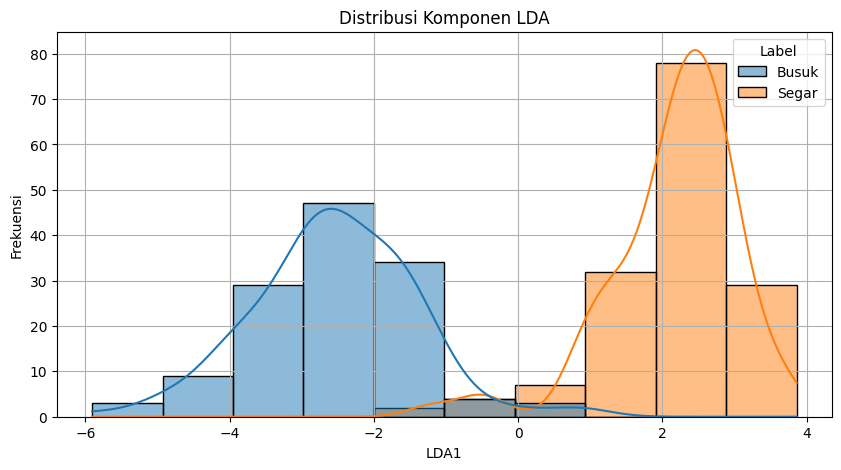

In [30]:
# Pisahkan fitur dan label
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

# Konversi label ke angka jika perlu
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Terapkan LDA
lda = LDA(n_components=1)  # Atur jumlah komponen LDA sesuai kebutuhan, maksimal = n_classes - 1
X_lda = lda.fit_transform(X, y_encoded)

# Jika ingin hasil dalam bentuk DataFrame
x_new = pd.DataFrame(X_lda, columns=['LDA1'])

# Visualisasi (opsional, hanya jika n_components > 1)
plt.figure(figsize=(10, 5))
sns.histplot(x=x_new['LDA1'], hue=y, kde=True)
plt.title('Distribusi Komponen LDA')
plt.xlabel('LDA1')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

## Membagi Data Train dan Test
Kode ini melakukan pembagian dataset fitur (`x_new`) dan label (`y`) menjadi data pelatihan (train) dan pengujian (test) menggunakan fungsi `train_test_split` dari scikit-learn. Parameter `test_size=0.3` menunjukkan bahwa 30% data dialokasikan untuk testing, sedangkan 70% sisanya untuk training. Pengaturan `random_state=42` digunakan agar pembagian data ini konsisten dan dapat direproduksi. Setelah pembagian, kode mencetak bentuk (shape) dari dataset train dan test untuk memastikan pembagian sudah sesuai.

In [31]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(224, 1)
(57, 1)


## Normalisasi Data dengan Mean dan Standar Deviasi
Kode ini melakukan normalisasi fitur pada data train dan test menggunakan metode standardisasi (z-score normalization). Data train dinormalisasi dengan mengurangi nilai rata-rata (`mean`) dan membagi dengan standar deviasi (`std`) dari data train itu sendiri agar fitur memiliki distribusi dengan rata-rata 0 dan standar deviasi 1. Data test juga dinormalisasi dengan mean dan std yang sama dari data train agar skala kedua dataset konsisten, menghindari data test 'melihat' informasi dari data test saat pelatihan.

In [32]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# MODELING
## Definisi Fungsi dan Classifier untuk Evaluasi Klasifikasi
Kode ini mendefinisikan fungsi `generateClassificationReport` untuk mencetak laporan evaluasi model klasifikasi yang mencakup classification report (precision, recall, f1-score), confusion matrix, dan akurasi. Selain itu, tiga algoritma klasifikasi didefinisikan: Random Forest dengan 5 pohon keputusan, Support Vector Machine (SVM) dengan kernel RBF, dan K-Nearest Neighbors (KNN) dengan 5 tetangga. Ketiga model ini akan digunakan untuk melakukan pelatihan dan evaluasi pada dataset.

In [33]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

## Training dan Evaluasi Model Random Forest
Kode ini melatih model Random Forest menggunakan data latih (`X_train`, `y_train`). Setelah pelatihan selesai, model digunakan untuk melakukan prediksi pada data latih dan data uji (`X_test`). Hasil prediksi tersebut kemudian dievaluasi dengan fungsi `generateClassificationReport` yang menampilkan classification report, confusion matrix, dan akurasi untuk kedua set data. Tujuan dari langkah ini adalah untuk mengetahui seberapa baik model dapat mengklasifikasikan data yang sudah dilatih maupun data yang belum pernah dilihat sebelumnya (testing).

In [34]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       Busuk       0.99      0.97      0.98       101
       Segar       0.98      0.99      0.98       123

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224

[[ 98   3]
 [  1 122]]
Accuracy: 0.9821428571428571

------Testing Set------
              precision    recall  f1-score   support

       Busuk       1.00      0.96      0.98        28
       Segar       0.97      1.00      0.98        29

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

[[27  1]
 [ 0 29]]
Accuracy: 0.9824561403508771


## Training dan Evaluasi Model SVM
Kode ini melatih model Support Vector Machine (SVM) dengan kernel RBF menggunakan data latih (`X_train`, `y_train`). Setelah model dilatih, prediksi dilakukan pada data latih dan data uji (`X_test`). Fungsi `generateClassificationReport` digunakan untuk menampilkan metrik evaluasi seperti classification report, confusion matrix, dan akurasi pada kedua set data. Langkah ini bertujuan mengukur performa model SVM dalam mengklasifikasikan citra dengan fitur GLCM yang telah diekstraksi.

In [35]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       Busuk       0.94      0.97      0.96       101
       Segar       0.97      0.95      0.96       123

    accuracy                           0.96       224
   macro avg       0.96      0.96      0.96       224
weighted avg       0.96      0.96      0.96       224

[[ 98   3]
 [  6 117]]
Accuracy: 0.9598214285714286

------Testing Set------
              precision    recall  f1-score   support

       Busuk       1.00      1.00      1.00        28
       Segar       1.00      1.00      1.00        29

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

[[28  0]
 [ 0 29]]
Accuracy: 1.0


## Training dan Evaluasi Model KNN
Kode ini melatih model K-Nearest Neighbors (KNN) dengan `k=5` menggunakan data latih (`X_train`, `y_train`). Setelah pelatihan selesai, model melakukan prediksi pada data latih dan data uji (`X_test`). Fungsi `generateClassificationReport` kemudian digunakan untuk menampilkan hasil evaluasi berupa classification report, confusion matrix, dan akurasi untuk kedua set data tersebut. Proses ini bertujuan untuk menilai kemampuan model KNN dalam mengklasifikasikan fitur GLCM dari dataset apel busuk dan segar.

In [36]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       Busuk       0.98      0.95      0.96       101
       Segar       0.96      0.98      0.97       123

    accuracy                           0.97       224
   macro avg       0.97      0.97      0.97       224
weighted avg       0.97      0.97      0.97       224

[[ 96   5]
 [  2 121]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

       Busuk       1.00      1.00      1.00        28
       Segar       1.00      1.00      1.00        29

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

[[28  0]
 [ 0 29]]
Accuracy: 1.0


## Evaluasi dan Perbandingan Beberapa Model Klasifikasi
Kode ini melakukan pelatihan dan evaluasi tiga model klasifikasi: Random Forest, SVM, dan KNN, menggunakan data latih dan data uji yang sudah disiapkan. Setiap model dilatih pada `X_train` dan `y_train`, lalu dilakukan prediksi untuk data latih dan data uji. Akurasi hasil prediksi pada kedua data tersebut dihitung dan disimpan. Setelah seluruh model dievaluasi, hasil akurasi training dan testing ditampilkan untuk membandingkan performa masing-masing model. Terakhir, kode ini juga menentukan model dengan akurasi testing tertinggi dan menampilkannya sebagai model terbaik untuk klasifikasi dataset apel busuk dan segar.

In [37]:
models = [
    ('Random Forest', rf),
    ('SVM', svm),
    ('KNN', knn)
]

results = []

for name, model in models:
    # Training
    model.fit(X_train, y_train)
    
    # Evaluasi training
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Evaluasi testing
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Simpan hasil
    results.append((name, train_acc, test_acc))

# Tampilkan hasil
print("=== Model Evaluation Results ===")
for name, train_acc, test_acc in results:
    print(f"{name}\n - Training Accuracy : {train_acc:.4f}\n - Testing Accuracy  : {test_acc:.4f}\n")

# Cari akurasi testing tertinggi
best_model = max(results, key=lambda x: x[2])
print(f">>> Best Model: {best_model[0]} with Testing Accuracy = {best_model[2]:.4f}")


=== Model Evaluation Results ===
Random Forest
 - Training Accuracy : 0.9821
 - Testing Accuracy  : 0.9825

SVM
 - Training Accuracy : 0.9598
 - Testing Accuracy  : 1.0000

KNN
 - Training Accuracy : 0.9688
 - Testing Accuracy  : 1.0000

>>> Best Model: SVM with Testing Accuracy = 1.0000


# EVALUATION
Kode ini mendefinisikan fungsi `plot_confusion_matrix` untuk memvisualisasikan matriks kebingungan (confusion matrix) dari hasil prediksi model klasifikasi. Fungsi menerima label asli (`y_true`), prediksi model (`y_pred`), dan judul grafik sebagai input, kemudian menampilkan heatmap confusion matrix dengan palet warna biru. Fungsi ini kemudian dipanggil untuk ketiga model yang telah dilatih: Random Forest, SVM, dan KNN, guna menampilkan perbandingan visual performa masing-masing model pada data uji. Visualisasi ini membantu memahami kesalahan klasifikasi dan distribusi prediksi yang benar atau salah.

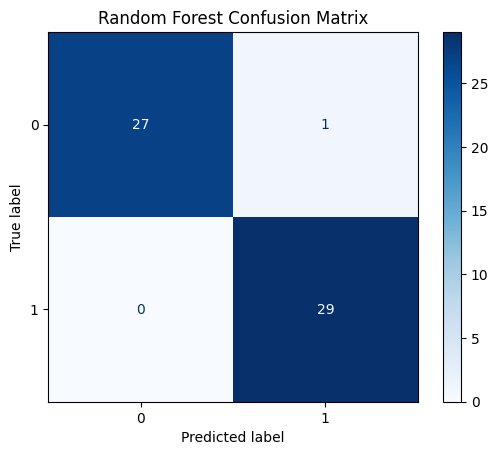

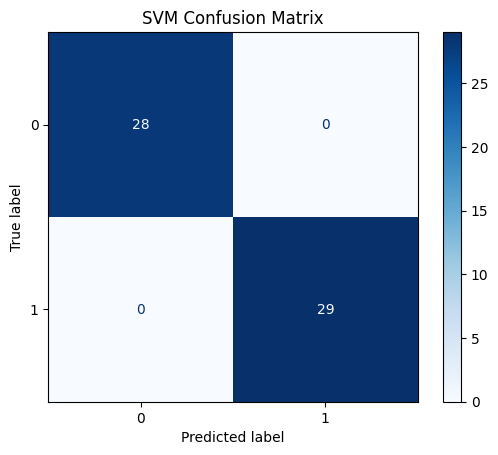

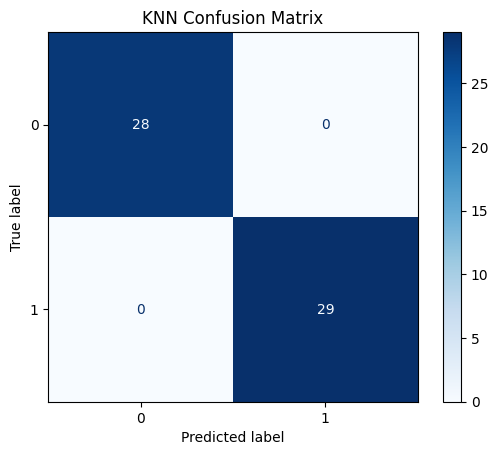

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")